In [6]:
#pip install pyramid.arima

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import timedelta
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from statsmodels.tsa.holtwinters import Holt
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA

### Helper functions

In [2]:
# Own Function
def cluster_select(df, col, cluster, attribute):
    df = df[df[col] == cluster]
    df = pd.DataFrame(df.groupby('days')[attribute].mean())
    return(df)


def movie_select(movie_name, df, attribute):
    movie_name = movie_name
    movies = df[df['replace'] == movie_name]
    movies.index = movies['days']
    movie = movies[[attribute]]
    return(movie)

In [3]:
def movie_calc_auto(df, days, exponential, smoothing_level, smoothing_slope):
    days = days
    test = df[365 - days:]
    train = df[:365 - days]
    train = train.dropna()
    
    # Naive
    dd = np.asarray(train)
    dd = np.repeat(dd[-1], len(test))
    y_hat = test.copy()
    y_hat['naive'] = dd[len(dd)-1]

    # Holt
    fit1 = Holt(np.asarray(train), exponential = exponential).fit(smoothing_level = smoothing_level, smoothing_slope = smoothing_slope)
    y_hat['holt'] = fit1.forecast(len(test))

    # Arima
    model = auto_arima(np.asarray(train), error_action='ignore', suppress_warnings=True)
    model.fit(train)

    forecast = model.predict(n_periods=len(test))
    y_hat['arima'] = forecast
    print(model)
    
    
    # Plot
    plt.plot(train, label = 'Train')
    plt.plot(test, label = 'Test')
    plt.plot(y_hat['arima'], label = 'Arima')
    plt.plot(y_hat['holt'], label = 'Holt')
    plt.plot(y_hat['naive'], label = 'Naive')
    plt.legend()
    plt.show

    rms_holt = sqrt(mse(test, y_hat['holt']))
    rms_arima = sqrt(mse(test, y_hat['arima']))
    rms_naive = sqrt(mse(test, y_hat['naive']))
    x = pd.DataFrame(np.array([rms_holt, rms_arima, rms_naive]), index = ['Holt', 'Arima', 'Naive'], columns = ['RMSE'])
    x = x.sort_values(by=['RMSE'])
    
    return(x)


def movie_calc_manual(df, days, exponential, smoothing_level, smoothing_slope, p, d, q):
    days = days
    test = df[365 - days:]
    train = df[:365 - days]
    train = train.dropna()
    
    # Naive
    dd = np.asarray(train)
    dd = np.repeat(dd[-1], len(test))
    y_hat = test.copy()
    y_hat['naive'] = dd[len(dd)-1]

    # Holt
    fit1 = Holt(np.asarray(train), exponential = exponential).fit(smoothing_level = smoothing_level, smoothing_slope = smoothing_slope)
    y_hat['holt'] = fit1.forecast(len(test))

    # Arima
    model = auto_arima(np.asarray(train), order = (p,d,q), error_action='ignore', suppress_warnings=True)
    model.fit(train)

    forecast = model.predict(n_periods=len(test))
    y_hat['arima'] = forecast
    
    
    # Plot
    plt.plot(train, label = 'Train')
    plt.plot(test, label = 'Test')
    plt.plot(y_hat['arima'], label = 'Arima')
    plt.plot(y_hat['holt'], label = 'Holt')
    plt.plot(y_hat['naive'], label = 'Naive')
    plt.legend()
    plt.show

    rms_holt = sqrt(mse(test, y_hat['holt']))
    rms_arima = sqrt(mse(test, y_hat['arima']))
    rms_naive = sqrt(mse(test, y_hat['naive']))
    x = pd.DataFrame(np.array([rms_holt, rms_arima, rms_naive]), index = ['Holt', 'Arima', 'Naive'], columns = ['RMSE'])
    x = x.sort_values(by=['RMSE'])
    
    return(x)

### 1. Load Data & Preprocessing

In [7]:
brand = pd.read_csv('../utils/alex_clusters.csv')

In [11]:
fb_1k = pd.read_table('../data/view_brand_rollup_facebook_1k-10k.tsv')
fb_10k = pd.read_table('../data/view_brand_rollup_facebook_10kplus.tsv')
fb = pd.concat([fb_1k, fb_10k])
fb = pd.merge(fb, brand, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')

insta_1k = pd.read_table('../data/view_brand_rollup_instagram_1k-10k.tsv')
insta_10k = pd.read_table('../data/view_brand_rollup_instagram_10kplus.tsv')
insta = pd.concat([insta_1k, insta_10k])
insta = pd.merge(insta, brand, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')

twit_1k = pd.read_table('../data/view_brand_rollup_twitter_1k-10k.tsv')
twit_10k = pd.read_table('../data/view_brand_rollup_twitter_10kplus.tsv')
twit = pd.concat([twit_1k, twit_10k])
twit = pd.merge(twit, brand, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')

In [6]:
fb['data_for']= pd.to_datetime(fb['data_for']) 
fb['released_on'] = pd.to_datetime(fb['released_on'])
fb['days_after_release'] = fb['data_for'] - fb['released_on'] 
fb = fb[(fb['days_after_release'] <= '0 days') & (fb['days_after_release'] >= '-365 days')]
fb['days'] = fb['days_after_release'] + timedelta(days=365)

insta['data_for']= pd.to_datetime(insta['data_for']) 
insta['released_on'] = pd.to_datetime(insta['released_on'])
insta['days_after_release'] = insta['data_for'] - insta['released_on'] 
insta = insta[(insta['days_after_release'] <= '0 days') & (insta['days_after_release'] >= '-365 days')]
insta['days'] = insta['days_after_release'] + timedelta(days=365)

twit['data_for']= pd.to_datetime(twit['data_for']) 
twit['released_on'] = pd.to_datetime(twit['released_on'])
twit['days_after_release'] = twit['data_for'] - twit['released_on'] 
twit = twit[(twit['days_after_release'] <= '0 days') & (twit['days_after_release'] >= '-365 days')]
twit['days'] = twit['days_after_release'] + timedelta(days=365)

### 2. Selecting Movie / Cluster and Data Column for Prediction

In [7]:
fb_movie = cluster_select(fb, 'clusters_3', 1, 'total_post_interactions')

### 3. Split train/test

<function matplotlib.pyplot.show(*args, **kw)>

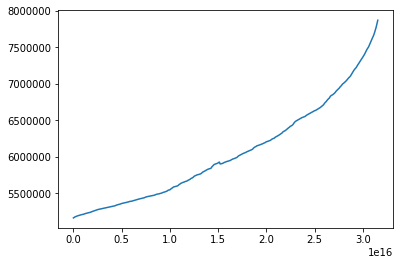

In [8]:
plt.plot(fb_movie)
plt.show

Looking at the plot, 150 days out might give wildly inaccurate forecasts because of the exponential trend appearing much later. At day 250 (~100 days out would be a benchmark) as it would give producers insights on how the trend would look like 3 months out. If it is not desirable, producers can therefore try to change metrics. 

We will try:

__90 days (3 months)__

__60 days (2 months)__ 

__30 days (1 month)__

In [34]:
days = 90
test = fb_movie[365 - days:]
train = fb_movie[:365 - days]

<function matplotlib.pyplot.show(*args, **kw)>

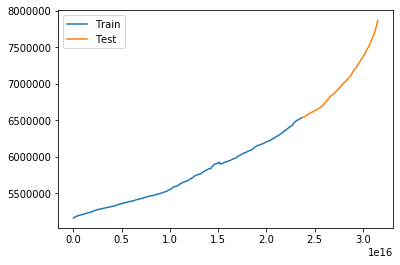

In [35]:
plt.figure()
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.legend(loc='best')
plt.show

### 4. Train Models

We will use different models:

a. Naive (basic model to compare against)

b. Holt's Linear (we will not use holt winters because data does not have seasonal trend)

d. ARIMA 

### 90 Days

#### a. Naive 

In [36]:
dd = np.asarray(train)
dd = np.repeat(dd[-1], len(test))
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]

RMSE is:  604057.71


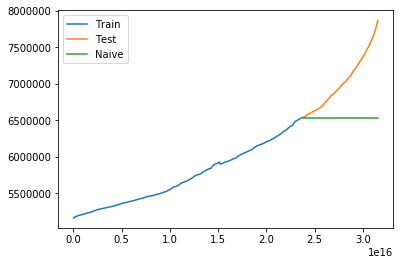

In [37]:
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(y_hat['naive'], label = 'Naive')
plt.legend()
plt.show

rms_naive = sqrt(mse(test, y_hat.naive))
print('RMSE is: ', round(rms_naive,2))

#### b. Holt's Linear
As we see an increasing exponential trend, we will use set exponential parameter as True and tune smoothing_level and smoothing_slope. (To be done later)

In [130]:
exponential = True
smoothing_level = 0.8
smoothing_slope = 0.2

y_hat_holt= test.copy()

fit1 = Holt(np.asarray(train), exponential = exponential).fit(smoothing_level = smoothing_level, smoothing_slope = smoothing_slope)
y_hat_holt['holt'] = fit1.forecast(len(test))

RMSE is:  202360.53


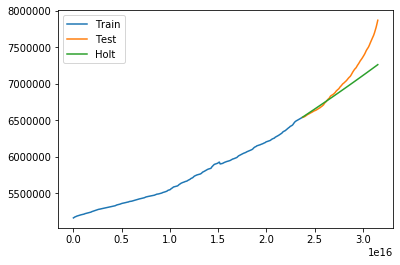

In [131]:
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(y_hat_holt['holt'], label = 'Holt')
plt.legend()
plt.show

rms_holt = sqrt(mse(test, y_hat_holt['holt']))
print('RMSE is: ', round(rms_holt,2))

#### 3. Arima (auto-arima)

In [132]:
model = auto_arima(np.asarray(train), trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

y_hat_arima = test.copy()
forecast = model.predict(n_periods=len(test))
y_hat_arima['arima'] = forecast

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=5273.225, BIC=5294.882, Time=0.209 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=5253.212, BIC=5260.431, Time=0.012 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=5257.033, BIC=5267.861, Time=0.074 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=5260.778, BIC=5271.607, Time=0.053 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=5251.220, BIC=5254.829, Time=0.008 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=5264.044, BIC=5278.482, Time=0.046 seconds
Total fit time: 0.411 seconds


RMSE is:  316454.99


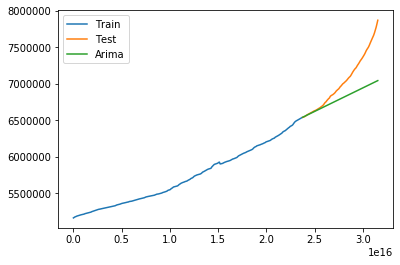

In [133]:
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(y_hat_arima['arima'], label = 'Arima')
plt.legend()
plt.show

rms_arima = sqrt(mse(test, y_hat_arima['arima']))
print('RMSE is: ', round(rms_arima,2))

### 60 days

ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)


,RMSE
Arima,81795.863427
Holt,101984.384453
Naive,527224.130101


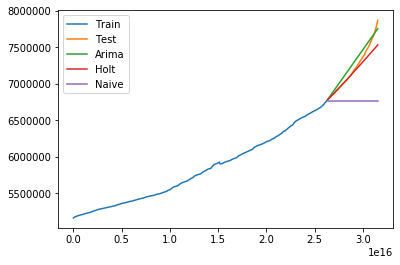

In [135]:
movie_calc_auto(fb_movie, 60, True, 0.8, 0.2)

### 30 Days

ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)


,RMSE
Arima,35459.143887
Holt,105403.996689
Naive,370127.285382


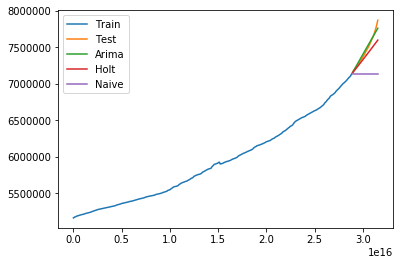

In [136]:
movie_calc_auto(fb_movie, 30, True, 0.8, 0.2)

## ARIMA(0,2,0) performs best for movies in this cluster. Let's try it with a few movies within the cluster

In [9]:
movie_clusters = fb[fb['clusters_3'] == 1]['replace'].unique()

__Movie 1: Divergent__

In [10]:
rand_movie = movie_clusters[0]
rand_movie

'Divergent'

,RMSE
Naive,1.034137e+06
Arima,2.509123e+06
Holt,1.904367e+07


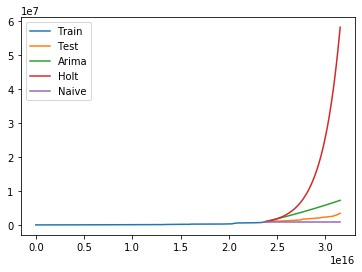

In [11]:
select = movie_select(rand_movie, fb, 'total_post_interactions')
movie_calc_manual(select, 90, True, 0.8, 0.2, 0, 2, 0)

__Movie 2: Pixels__

In [12]:
rand_movie = movie_clusters[1]
rand_movie

'Pixels'

,RMSE
Arima,29421.872723
Holt,148014.538122
Naive,235542.006557


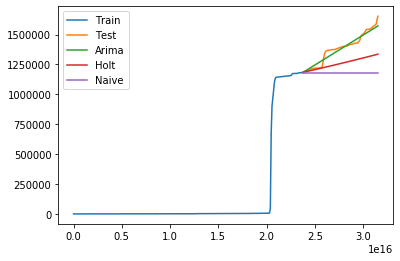

In [13]:
select = movie_select(rand_movie, fb, 'total_post_interactions')
movie_calc_manual(select, 90, True, 0.8, 0.2, 0, 2, 0)

__Movie 3: The Hunger Games__

In [142]:
rand_movie = movie_clusters[2]
rand_movie

'The Hunger Games'

,RMSE
Holt,275378.653145
Arima,481885.790740
Naive,752400.499692


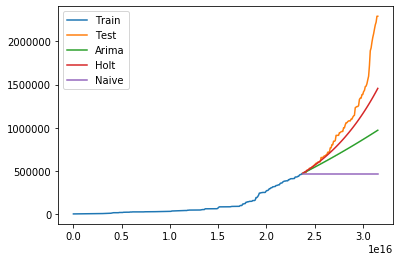

In [144]:
select = movie_select(rand_movie, fb, 'total_post_interactions')
movie_calc_manual(select, 90, True, 0.8, 0.2, 2, 0, 2)

__Movie 4: Big Hero 6__

In [145]:
rand_movie = movie_clusters[4]
rand_movie

'Big Hero 6'

,RMSE
Holt,83594.375541
Arima,183280.857017
Naive,282749.913933


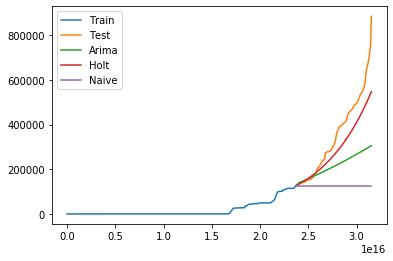

In [146]:
select = movie_select(rand_movie, fb, 'total_post_interactions')
movie_calc_manual(select, 90, True, 0.8, 0.2, 2, 0, 2)

__Movie 5: Captain America__

In [147]:
rand_movie = movie_clusters[8]
rand_movie

'Captain America: The Winter Soldier'

,RMSE
Arima,1.300004e+06
Naive,1.878171e+06
Holt,2.415270e+06


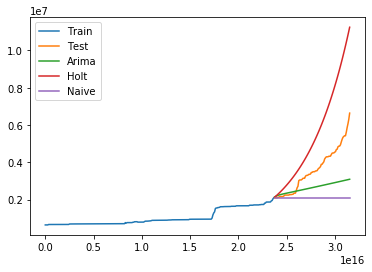

In [149]:
select = movie_select(rand_movie, fb, 'total_post_interactions')
movie_calc_manual(select, 90, True, 0.8, 0.2, 2, 0, 2)

__Movie 6: Avenger: Endgame__

In [152]:
rand_movie = movie_clusters[-2]
rand_movie

'Avengers: Endgame'

,RMSE
Arima,9.298909e+05
Holt,1.206684e+06
Naive,1.359694e+06


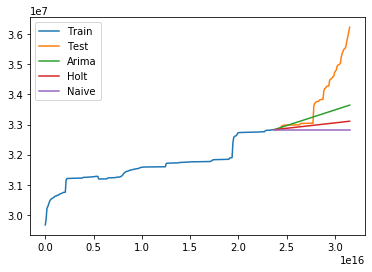

In [153]:
select = movie_select(rand_movie, fb, 'total_post_interactions')
movie_calc_manual(select, 90, True, 0.8, 0.2, 2, 0, 2)

,RMSE
Holt,659427.422077
Arima,712635.323309
Naive,883659.734507


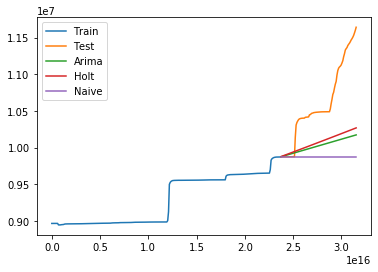

In [154]:
rand_movie = movie_clusters[-5]
select = movie_select(rand_movie, fb, 'total_post_interactions')
movie_calc_manual(select, 90, True, 0.8, 0.2, 2, 0, 2)